# Classification Algorithms

Tìm hiểu về bài toán phân lớp và triển khai bài toán này bằng ngôn ngữ Python.

1.   Thuật toán phân lớp: Decision Tree, Naïve Bayes, KNN (K-Nearest Neighbors), Logistic Regression.

2.   Phương pháp tìm kiếm tham số phù hợp GridSearch.

3. Phương pháp cân bằng dữ liệu.

Nhóm thực hiện: 3

Bộ dữ liệu thực hiện: Social Network Ads

# Environment set up

## Import libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import GridSearchCV

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample 
from imblearn.ensemble import BalancedBaggingClassifier 

## Import data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! unzip '/content/drive/MyDrive/Datasets/social_network_ads'

Archive:  /content/drive/MyDrive/Datasets/social_network_ads.zip
  inflating: Social_Network_Ads.csv  


In [ ]:
df = pd.read_csv('/content/Social_Network_Ads.csv')
df

,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510,Male,19,19000,0
1,15810944,Male,35,20000,0
2,15668575,Female,26,43000,0
3,15603246,Female,27,57000,0
4,15804002,Male,19,76000,0
...,...,...,...,...,...
395,15691863,Female,46,41000,1
396,15706071,Male,51,23000,1
397,15654296,Female,50,20000,1
398,15755018,Male,36,33000,0


Đây là bộ dữ liệu nhằm phân khúc đối tượng trong quảng tiếp thị sản phẩm. Ta có: 

- Các cột 'UserID', 'Gender', 'Age' và 'EstimatedSalary' là các thuộc tính thông tin của khách hàng được đưa vào xem xét. 

- Cột 'Purchased' là nhãn của mẫu. 
    + Nếu giá trị của 'Purchased' là 1 tức là người đó có khả năng mua hàng.
    + Còn 0 là ngược lại.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   User ID          400 non-null    int64 
 1   Gender           400 non-null    object
 2   Age              400 non-null    int64 
 3   EstimatedSalary  400 non-null    int64 
 4   Purchased        400 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 15.8+ KB


Bộ dữ liệu có tổng cộng 400 mẫu và ta có các cột đều có kiểu dữ liệu int64 ngoài trừ 'Gender' mang kiểu dữ liệu object.

## Data analysis

In [ ]:
df['Purchased'].value_counts()

0    257
1    143
Name: Purchased, dtype: int64

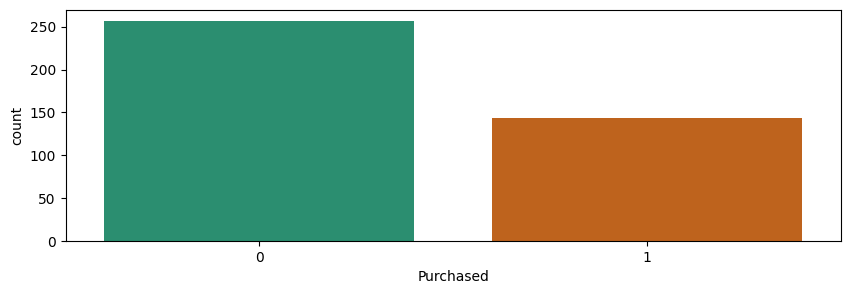

In [ ]:
plt.figure(figsize=(10, 3))
sns.countplot(x='Purchased', data=df, palette='Dark2')
plt.show()

<Figure size 1000x300 with 0 Axes>

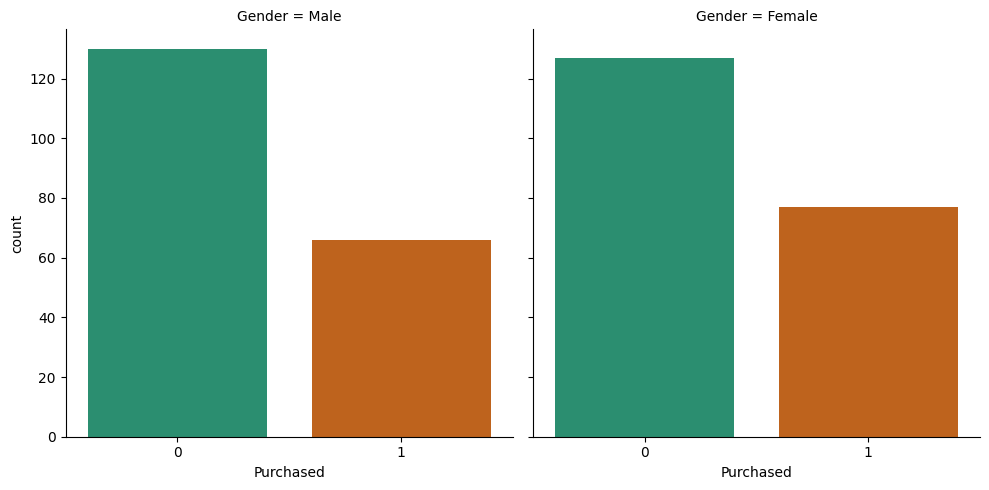

In [ ]:
plt.figure(figsize=(10, 3))
sns.catplot(x='Purchased', col='Gender', kind='count', data=df, palette='Dark2')
plt.show()

In [ ]:
pd.crosstab(df.Gender, df.Purchased, normalize='index').style.background_gradient(cmap='crest')

Purchased,0,1
Gender,,
Female,0.622549,0.377451
Male,0.663265,0.336735


<Axes: xlabel='Age', ylabel='Count'>

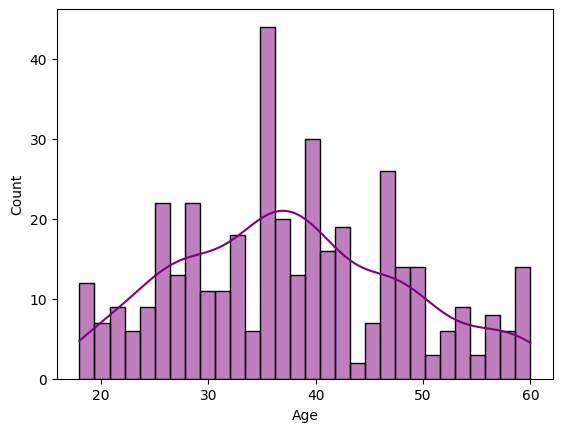

In [ ]:
sns.histplot(df['Age'], kde=True, color='purple', bins=30)

<Axes: xlabel='EstimatedSalary', ylabel='Count'>

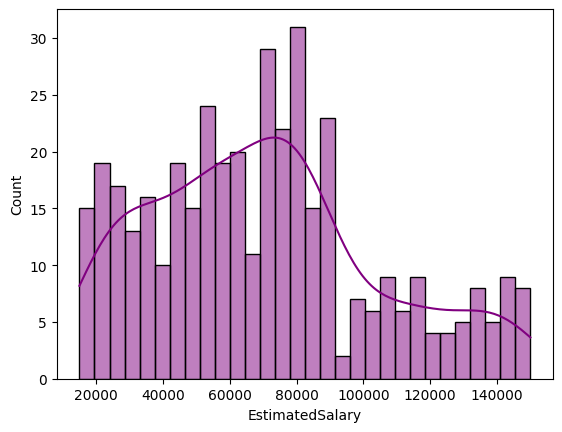

In [ ]:
sns.histplot(df['EstimatedSalary'], kde=True, color='purple', bins=30)

## Preprocessing

In [ ]:
# Chuyển đối giá trị của cột 'Gender' về với int64
# Nếu là 'Male' sẽ mang giá trị 1, còn 'Female' thì mang giá trị 0
df['Gender'] = np.where(df['Gender'] == 'Male', 1, 0)

In [ ]:
# Gán 'Purchased' thành label, và các cột 'Gender', 'Age', 'EstimatedSalary' là data
label = ['Gender', 'Age', 'EstimatedSalary']
X = df[:][label]
y = df['Purchased'].to_numpy()

In [ ]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
X = pd.DataFrame(X, columns =['Gender','Age', 'EstimatedSalary'])

In [ ]:
X

,Gender,Age,EstimatedSalary
0,1.0,0.023810,0.029630
1,1.0,0.404762,0.037037
2,0.0,0.190476,0.207407
3,0.0,0.214286,0.311111
4,1.0,0.023810,0.451852
...,...,...,...
395,0.0,0.666667,0.192593
396,1.0,0.785714,0.059259
397,0.0,0.761905,0.037037
398,1.0,0.428571,0.133333


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=None, shuffle=True)

# Experimenting classification algorithms

Thực nghiệm sẽ diễn ra giữa các thuật toán phân lớp lần lượt với:

  - Dữ liệu gốc
  - Dữ liệu với số mẫu đã được thay đổi
    + Under-sampling
    + Up-sampling
  - Dùng GridSearchCV để tìm tham số tối ưu cho từng mô hình

In [ ]:
def cf_visualize(y_test, y_pred, ax=None):
    ax = ax or plt.gca()
    cf = confusion_matrix(y_test, y_pred)
    
    labels = np.unique(y_train)
    df_confusion = pd.DataFrame(cf, index=labels, columns=labels)
    
    # get percentages
    df_percentages = df_confusion.div(df_confusion.sum(axis=1), axis=0)
    
    #plt.figure(figsize=(5, 4))
    #sns.set(font_scale=1.2)
    
    ax = sns.heatmap(data=df_percentages * 100, annot=True, cmap='Blues', fmt='.1f')
    
    #ax.set_title('Confusion Matrix\n', size=15)
    ax.set_xlabel('Predicted Values', size = 12)
    ax.set_ylabel('Actual values', size = 12)

    return ax

In [ ]:
def run_with_model(X, y, X_test, model):
  model.fit(X, y)
  y_pred = model.predict(X_test)
  return y_pred

In [ ]:
def experiment_result(y_test, y_pred):
  result = []
  result.append(accuracy_score(y_pred=y_pred, y_true=y_test))
  result.append(precision_score(y_pred=y_pred, y_true=y_test))
  result.append(recall_score(y_pred=y_pred, y_true=y_test))
  result.append(f1_score(y_pred=y_pred, y_true=y_test))
  return result

In [ ]:
def experiment(X, y, X_test, y_test):
  result = []
  dt = DecisionTreeClassifier()
  nb = GaussianNB()
  knn = KNeighborsClassifier(n_neighbors=3)
  lr = LogisticRegression()

  y_pred_dt = run_with_model(X, y, X_test, dt)
  y_pred_nb = run_with_model(X, y, X_test, nb)
  y_pred_knn = run_with_model(X, y, X_test, knn)
  y_pred_lr = run_with_model(X, y, X_test, lr)

  fig, ax = plt.subplots(2, 2, figsize=(15, 11))

  plt.subplot(2, 2, 1).set_title('Decision Tree')
  cf_visualize(y_test, y_pred_dt) #, ax[0, 0])
  #plt.subplot(2, 2, 1)

  plt.subplot(2, 2, 2).set_title('Naive Bayes')
  cf_visualize(y_test, y_pred_nb)#, ax[0, 1])

  plt.subplot(2, 2, 3).set_title('K-nearest Neighbor')
  cf_visualize(y_test, y_pred_knn)#, ax[1, 0])
  
  plt.subplot(2, 2, 4).set_title('Logistic Regression')
  cf_visualize(y_test, y_pred_lr)
  
  plt.show()

  result.append(experiment_result(y_test, y_pred_dt))
  result.append(experiment_result(y_test, y_pred_nb))
  result.append(experiment_result(y_test, y_pred_knn))
  result.append(experiment_result(y_test, y_pred_lr))

  return result

## With original data

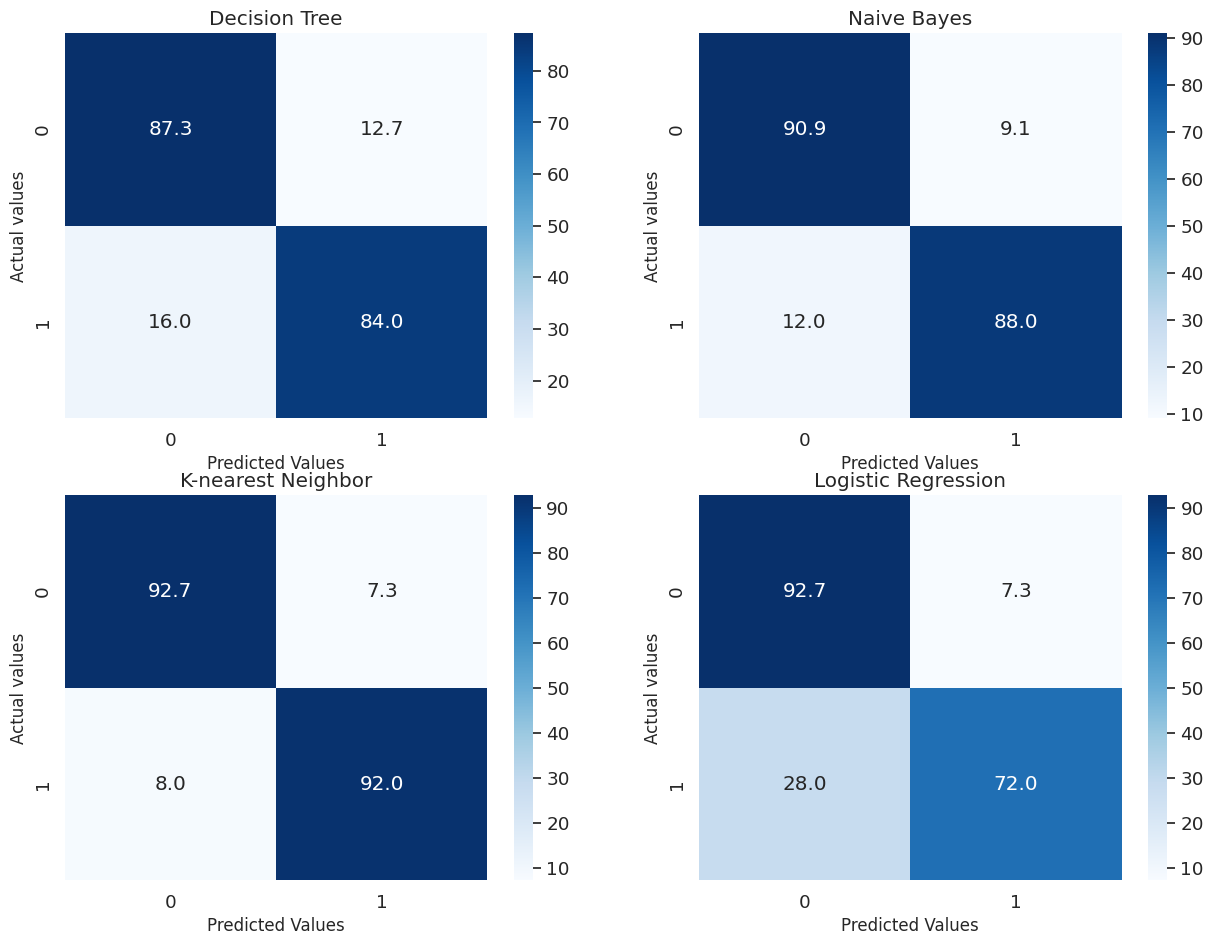

In [ ]:
result = experiment(X_train, y_train, X_test, y_test)

## With resampling data

In [ ]:
pd.DataFrame(y_train).value_counts()

0    202
1    118
dtype: int64

### Undersample

In [ ]:
nearmiss = RandomUnderSampler(
    sampling_strategy={0: 118}
)

X_undersampled, y_undersampled = nearmiss.fit_resample(X_train, y_train)

In [ ]:
pd.DataFrame(y_undersampled).value_counts()

0    118
1    118
dtype: int64

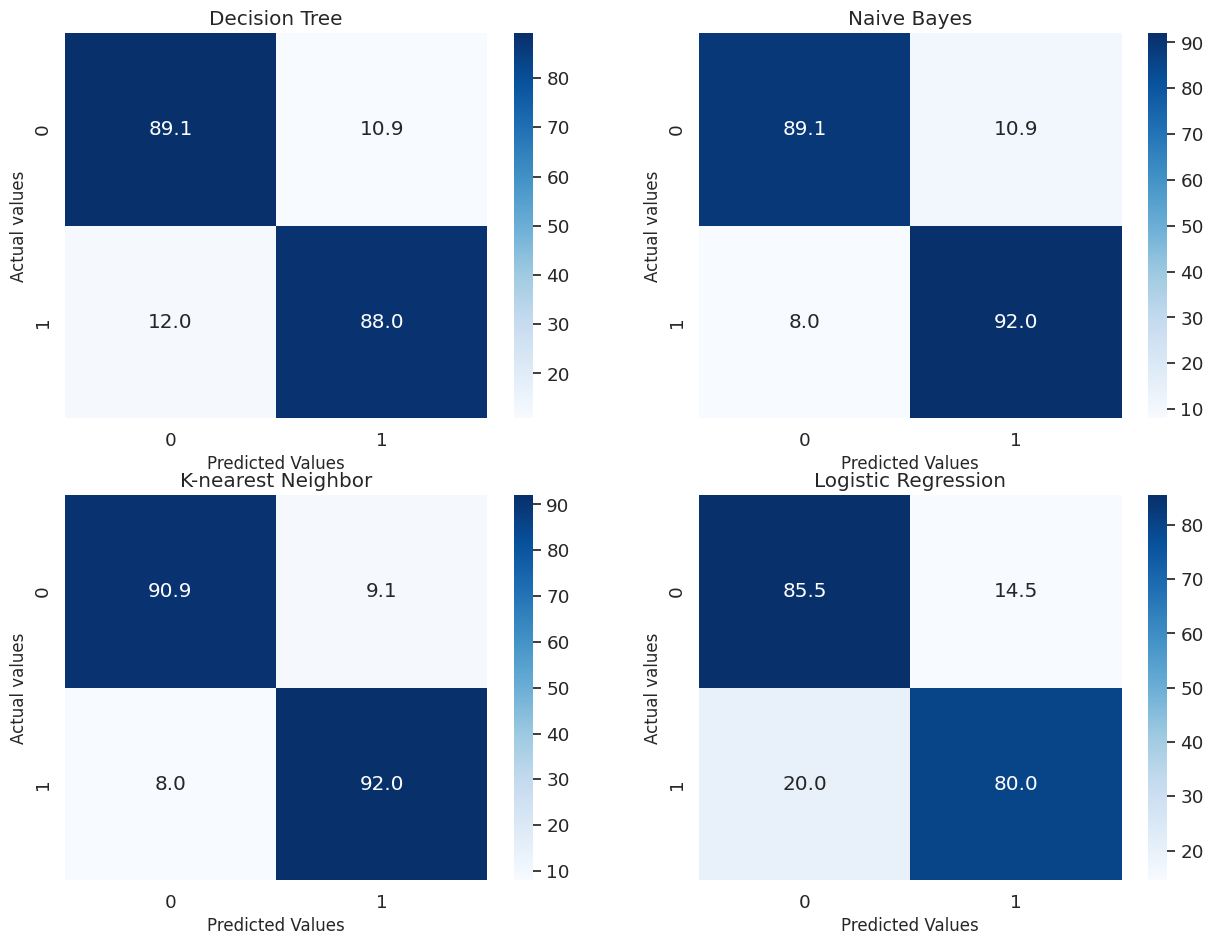

In [ ]:
under_result = experiment(X_undersampled, y_undersampled, X_test, y_test)

### Upsample

In [ ]:
X_upsampled, y_upsampled = SMOTE().fit_resample(X_train, y_train)

In [ ]:
pd.DataFrame(y_upsampled).value_counts()

0    202
1    202
dtype: int64

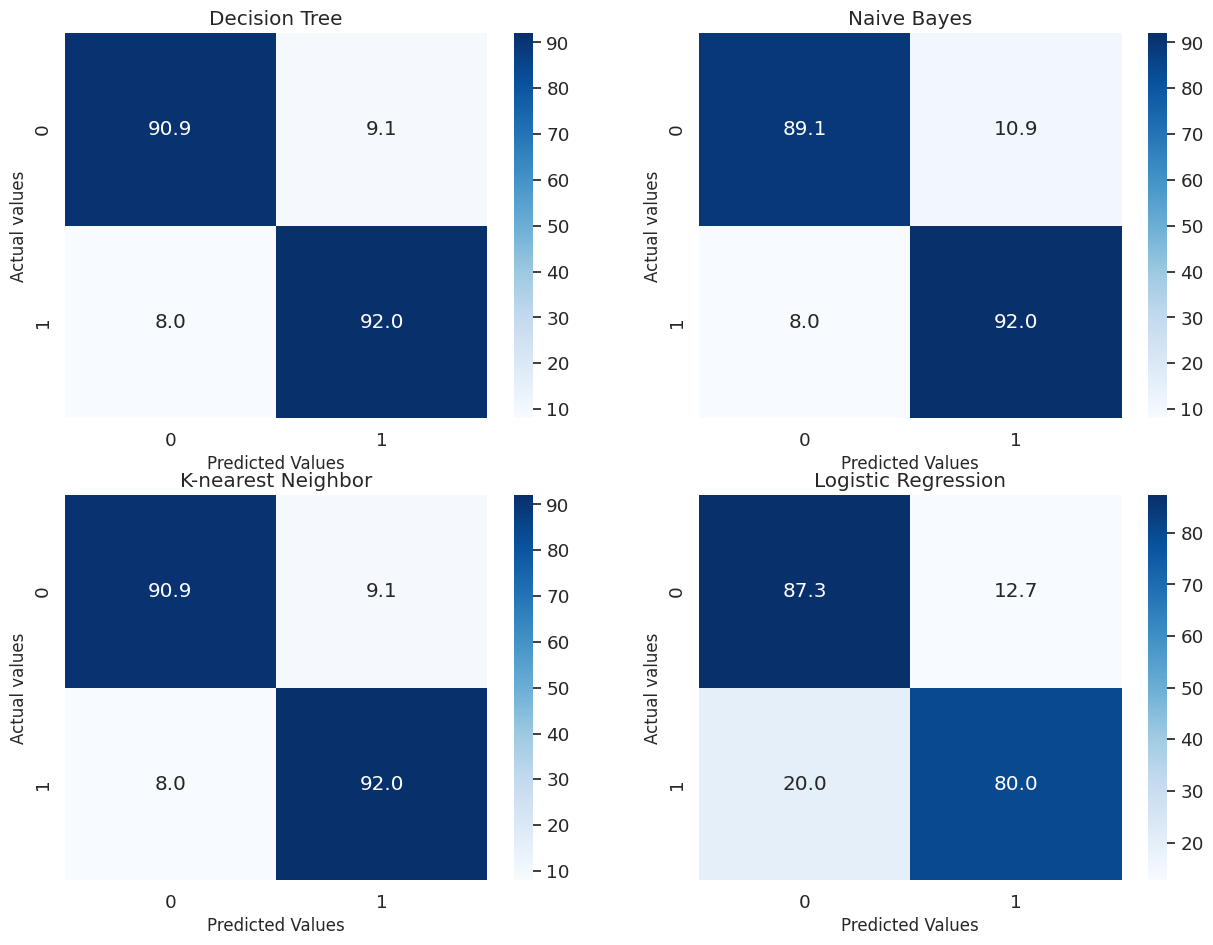

In [ ]:
up_result = experiment(X_upsampled, y_upsampled, X_test, y_test)

## With gird search

### Decision Tree

In [ ]:
parameters = {
    "criterion": ['gini', 'entropy'],
    "max_depth": [2, 3, 5, 10, 20],
    "min_samples_split": [5, 10, 20, 50, 100],
    "min_samples_leaf": range(1,5)
}

In [ ]:
# Create grid search object
grid_dt = GridSearchCV(estimator = DecisionTreeClassifier(),
             param_grid = parameters,
             scoring = ['accuracy', 'precision', 'recall', 'f1'], #sklearn.metrics.SCORERS.keys()
             refit='accuracy',
             verbose = 4,
             n_jobs = -1)

In [ ]:
grid_dt = grid_dt.fit(X_train, y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


In [ ]:
grid_dt.best_score_

0.90625

In [ ]:
grid_dt.best_params_

{'criterion': 'gini',
 'max_depth': 5,
 'min_samples_leaf': 1,
 'min_samples_split': 20}

In [ ]:
best_dt = DecisionTreeClassifier(criterion='gini', max_depth=5, min_samples_leaf=1, min_samples_split=20)

### Naive Bayes

In [ ]:
from sklearn.preprocessing import PowerTransformer
#params = np.logspace(0, -9, num=10)
params = {'var_smoothing': np.logspace(0,-9, num=100)}

grid_nb = GridSearchCV(estimator=GaussianNB(), cv=10, param_grid=params, verbose=1, scoring='accuracy')
Data_transformed = PowerTransformer().fit_transform(X_test)
grid_nb = grid_nb.fit(Data_transformed, y_test)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


In [ ]:
grid_nb.best_score_ 

0.875

In [ ]:
grid_nb.best_params_

{'var_smoothing': 0.008111308307896872}

In [ ]:
best_nb = GaussianNB(var_smoothing=0.008111308307896872)

### K-nearest Neighbor

In [ ]:
knn = KNeighborsClassifier()
k_range = list(range(1, 31))
param_grid = dict(n_neighbors=k_range)
  
# defining parameter range
grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy', return_train_score=False, verbose=1)
  
# fitting the model for grid search
grid_knn = grid.fit(X_train, y_train)

Fitting 10 folds for each of 30 candidates, totalling 300 fits


In [ ]:
grid_knn.best_params_

{'n_neighbors': 11}

In [ ]:
best_knn = KNeighborsClassifier(n_neighbors=11)

### Logistic Regression

In [ ]:
params = {'C': np.logspace(-3, 3, 7), 'penalty': ['l1', 'l2']}
grid_lr = GridSearchCV(LogisticRegression(), param_grid=params, cv=10, scoring='accuracy', return_train_score=False, verbose=1)
grid_lr.fit(X_train, y_train)

Fitting 10 folds for each of 14 candidates, totalling 140 fits


/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
70 fits failed out of a total of 140.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
70 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Solver l

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2']},
             scoring='accuracy', verbose=1)

In [ ]:
grid_lr.best_score_

0.840625

In [ ]:
grid_lr.best_params_

{'C': 100.0, 'penalty': 'l2'}

In [ ]:
best_lr = LogisticRegression(C=100.0, penalty='l2')

# Result summary

Tổng hợp kết quả có được khi thực nghiệm các mô hình phân lớp với tham số tự động (default-hyperparameter models) và mô hình với tham số đã được tối ưu với GridSearch lần lượt với dữ liệu gốc, dữ liệu được lấy mẫu xuống (under-sampling) và dữ liệu lấy mẫu lên (up-sampling).

In [ ]:
def create_result_table(result):
  column_values = ['Accuracy', 'Precision', 'Recall', 'F1']
  index_values = ['Decision Tree', 'Naive Bayes', 'K-nearest Neighbor', 'Logistic Regression']
  data = pd.DataFrame(data = result, 
                  index = index_values, 
                  columns = column_values)
  return data

## Default-hyperparameter models

### Original data

In [ ]:
table = create_result_table(result)
table

,Accuracy,Precision,Recall,F1
Decision Tree,0.8625,0.750000,0.84,0.792453
Naive Bayes,0.9000,0.814815,0.88,0.846154
K-nearest Neighbor,0.9250,0.851852,0.92,0.884615
Logistic Regression,0.8625,0.818182,0.72,0.765957


### Undersampling data

In [ ]:
under_table = create_result_table(under_result)
under_table

,Accuracy,Precision,Recall,F1
Decision Tree,0.8875,0.785714,0.88,0.830189
Naive Bayes,0.9000,0.793103,0.92,0.851852
K-nearest Neighbor,0.9125,0.821429,0.92,0.867925
Logistic Regression,0.8375,0.714286,0.80,0.754717


### Upsampling data

In [ ]:
up_table = create_result_table(up_result)
up_table

,Accuracy,Precision,Recall,F1
Decision Tree,0.9125,0.821429,0.92,0.867925
Naive Bayes,0.9000,0.793103,0.92,0.851852
K-nearest Neighbor,0.9125,0.821429,0.92,0.867925
Logistic Regression,0.8500,0.740741,0.80,0.769231


## Best param models found by GridSearch

In [ ]:
def gridsearch_experiment(X_train, y_train, X_test, y_test):
  y_pred_grid_dt = run_with_model(X_train, y_train, X_test, best_dt)
  y_pred_grid_nb = run_with_model(X_train, y_train, X_test, best_nb)
  y_pred_grid_knn = run_with_model(X_train, y_train, X_test, best_knn)
  y_pred_grid_lr = run_with_model(X_train, y_train, X_test, best_lr)

  fig, ax = plt.subplots(2, 2, figsize=(15, 11))

  plt.subplot(2, 2, 1).set_title('Decision Tree')
  cf_visualize(y_test, y_pred_grid_dt) #, ax[0, 0])

  plt.subplot(2, 2, 2).set_title('Naive Bayes')
  cf_visualize(y_test, y_pred_grid_nb)#, ax[0, 1])

  plt.subplot(2, 2, 3).set_title('K-nearest Neighbor')
  cf_visualize(y_test, y_pred_grid_knn)#, ax[1, 0])
    
  plt.subplot(2, 2, 4).set_title('Logistic Regression')
  cf_visualize(y_test, y_pred_grid_lr)
    
  plt.show()

  grid_result = []
  grid_result.append(experiment_result(y_test, y_pred_grid_dt))
  grid_result.append(experiment_result(y_test, y_pred_grid_nb))
  grid_result.append(experiment_result(y_test, y_pred_grid_knn))
  grid_result.append(experiment_result(y_test, y_pred_grid_lr))

  return grid_result

### Original data

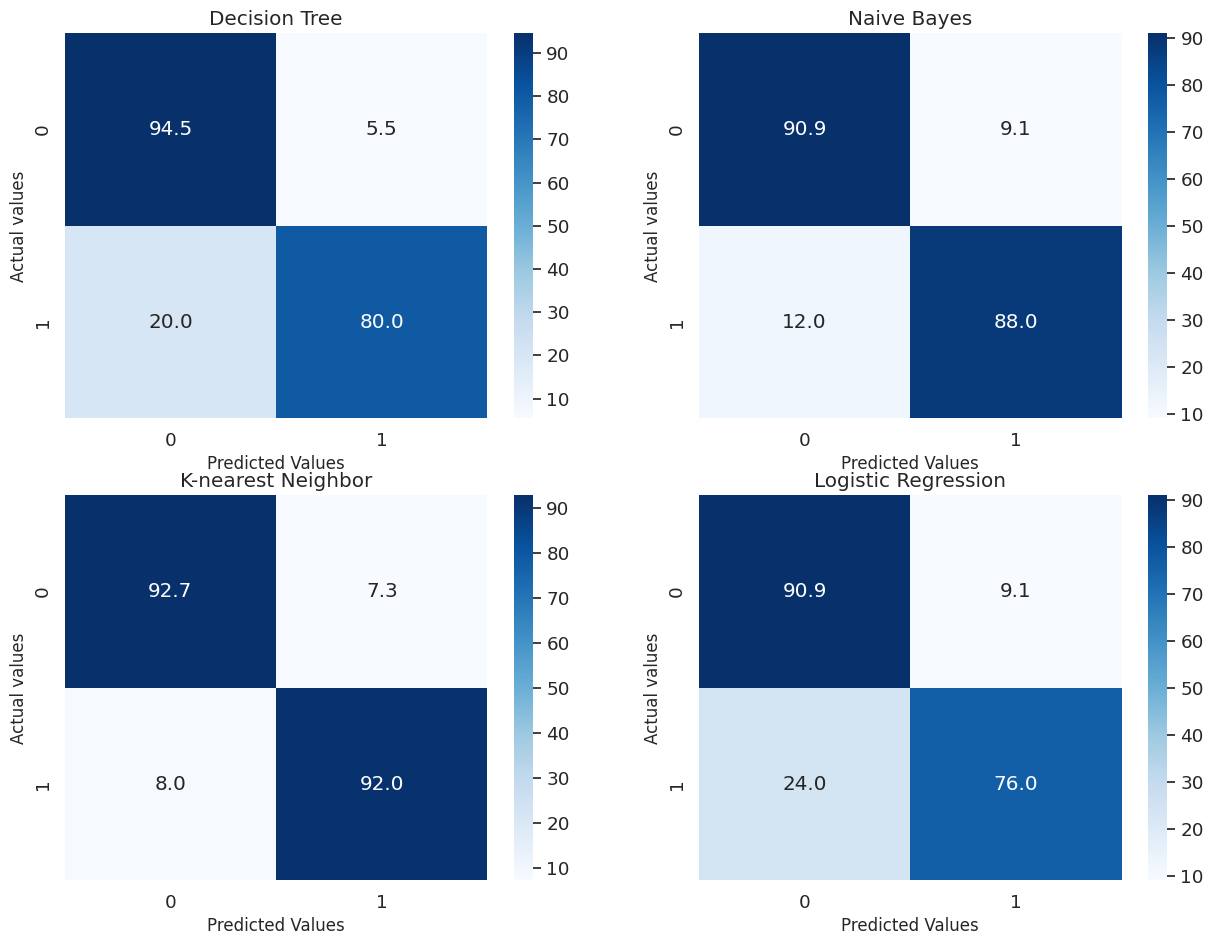

In [ ]:
grid_result = gridsearch_experiment(X_train, y_train, X_test, y_test)

In [ ]:
grid_table = create_result_table(grid_result)
grid_table

,Accuracy,Precision,Recall,F1
Decision Tree,0.9000,0.869565,0.80,0.833333
Naive Bayes,0.9000,0.814815,0.88,0.846154
K-nearest Neighbor,0.9250,0.851852,0.92,0.884615
Logistic Regression,0.8625,0.791667,0.76,0.775510


### Undersampling data

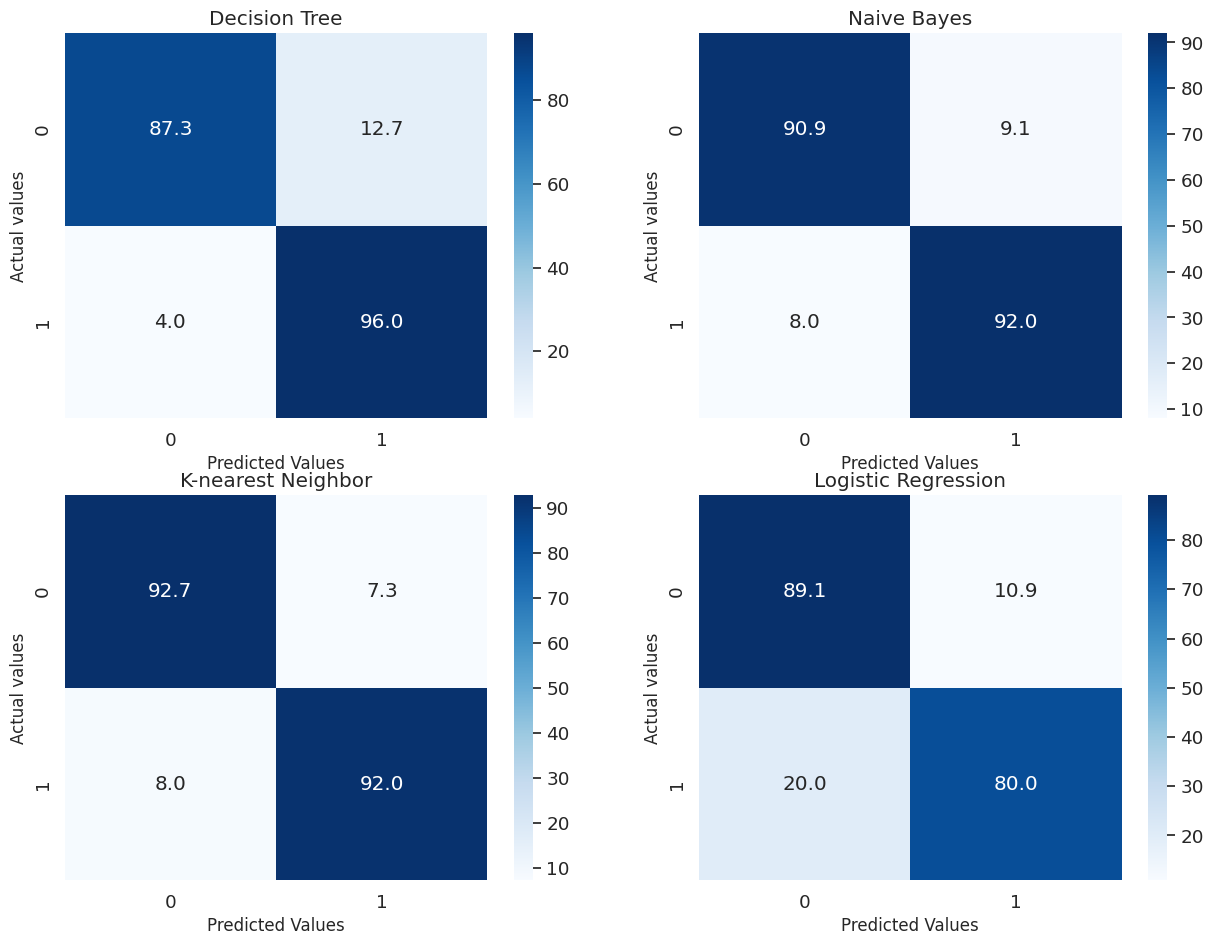

In [ ]:
grid_under_result = gridsearch_experiment(X_undersampled, y_undersampled, X_test, y_test)

In [ ]:
grid_under_table = create_result_table(grid_under_result)
grid_under_table

,Accuracy,Precision,Recall,F1
Decision Tree,0.9000,0.774194,0.96,0.857143
Naive Bayes,0.9125,0.821429,0.92,0.867925
K-nearest Neighbor,0.9250,0.851852,0.92,0.884615
Logistic Regression,0.8625,0.769231,0.80,0.784314


### Upsampling data

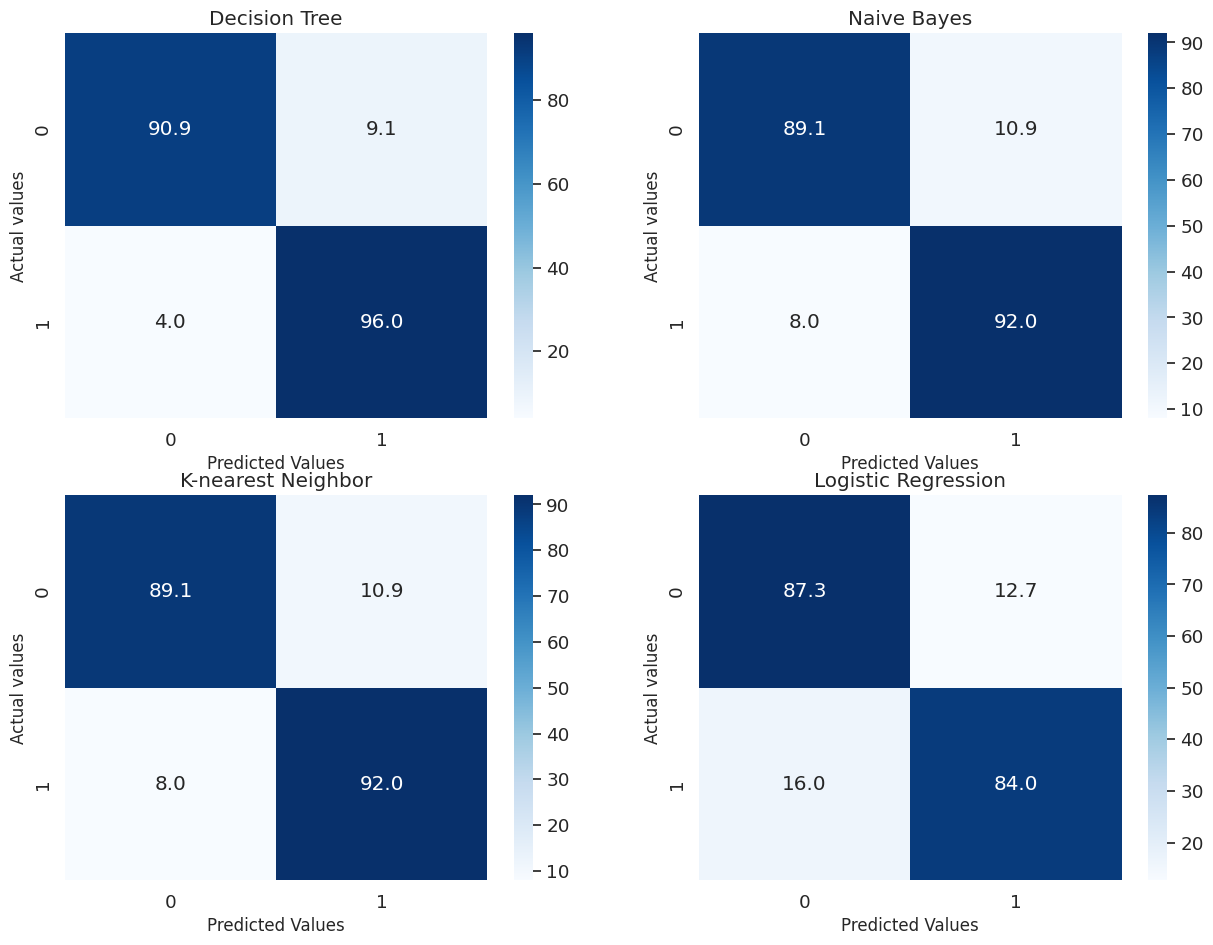

In [ ]:
grid_up_result = gridsearch_experiment(X_upsampled, y_upsampled, X_test, y_test)

In [ ]:
grid_up_table = create_result_table(grid_up_result)
grid_up_table

,Accuracy,Precision,Recall,F1
Decision Tree,0.9250,0.827586,0.96,0.888889
Naive Bayes,0.9000,0.793103,0.92,0.851852
K-nearest Neighbor,0.9000,0.793103,0.92,0.851852
Logistic Regression,0.8625,0.750000,0.84,0.792453
